In [51]:
import numpy as np
import pandas as pd
#Set the seed for reproducibility
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

In [72]:
train = pd.read_excel("train.xlsx")
train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
train['month'] = train['PRICES'].dt.month
train['day'] = train['PRICES'].dt.day
train['year'] = train['PRICES'].dt.year

train.isnull().sum().sum() #no null values
train.isna().sum().sum() #no NA values

train['day of week']=train['PRICES'].dt.dayofweek
print(train.head(10))

      PRICES  Hour 01  Hour 02  Hour 03  Hour 04  Hour 05  Hour 06  Hour 07  \
0 2007-01-01    24.31    24.31    21.71     8.42     0.01     0.01     0.02   
1 2007-01-02    16.01    11.00     9.01     7.50     9.00     7.45    16.50   
2 2007-01-03    28.00    24.50    24.15    18.99    15.50    23.11    29.01   
3 2007-01-04    31.01    28.69    27.00    24.20    12.02    27.00    28.00   
4 2007-01-05    22.00    19.50    17.55    15.91    11.40    22.65    27.30   
5 2007-01-06    25.00    22.99    20.99    18.00    16.95    20.01    20.00   
6 2007-01-07    22.00    18.29    16.59     9.17     8.00     8.19     9.01   
7 2007-01-08    13.00    13.00    10.00     3.40    10.00    13.00    24.01   
8 2007-01-09    18.51    16.81    13.01    10.01     8.17    16.00    26.00   
9 2007-01-10    12.43    15.09    13.04    12.01    11.26    16.00    21.01   

   Hour 08  Hour 09  ...  Hour 19  Hour 20  Hour 21  Hour 22  Hour 23  \
0     0.01     0.01  ...    37.99    33.11    37.99    33

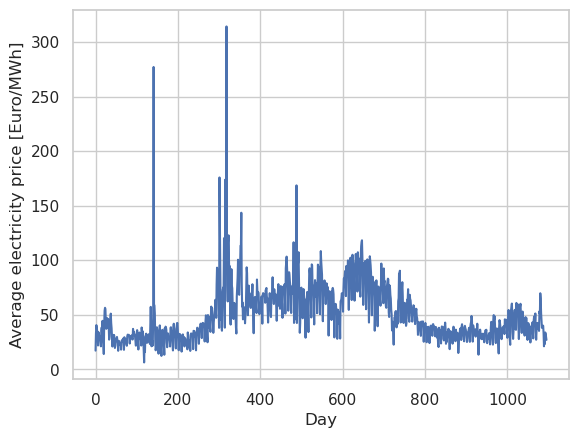

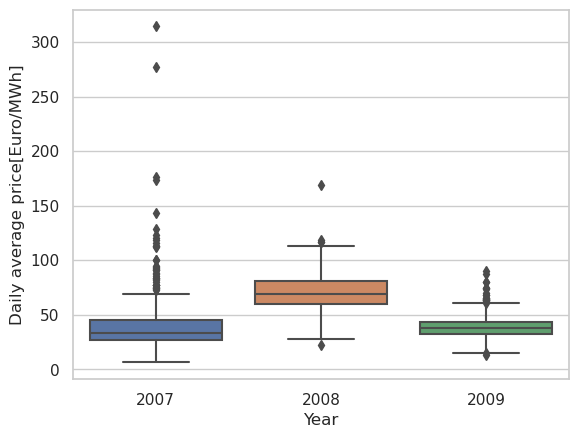

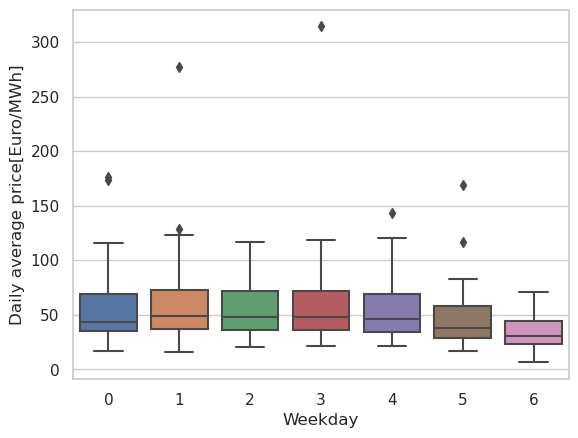

In [69]:
no_days=train.shape[0]
daily_averages=np.zeros(no_days)
for i in range(no_days):
    daily_averages[i]=np.mean(train.iloc[i,1:25])
train['daily average']=daily_averages #these are correct, checked on excel
plt.plot(daily_averages)
plt.xlabel('Day')
plt.ylabel('Average electricity price [Euro/MWh]')
plt.show()


sb.boxplot(x='year', y='daily average' , data=train)
plt.xlabel("Year")
plt.ylabel('Daily average price[Euro/MWh]')
plt.show()

sb.boxplot(x='day of week', y= 'daily average', data=train )
plt.xlabel("Weekday")
plt.ylabel('Daily average price[Euro/MWh]')
plt.show()

### STL decomposition

In [106]:
train['daily average'] = daily_averages
train['date'] = train['PRICES'] 

# Keep only 'date' and 'daily average' columns
train = train[['date', 'daily average']]

# Set 'date' as the index (double-check the type)
train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace=True)

# Extract the 'daily average' column as a Series
ts = train['daily average']

Original ETS Decomposition:

Smoothed ETS Decomposition:


In [40]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import seaborn as sns

stl = STL(ts, seasonal=7, trend=365)
res = stl.fit()

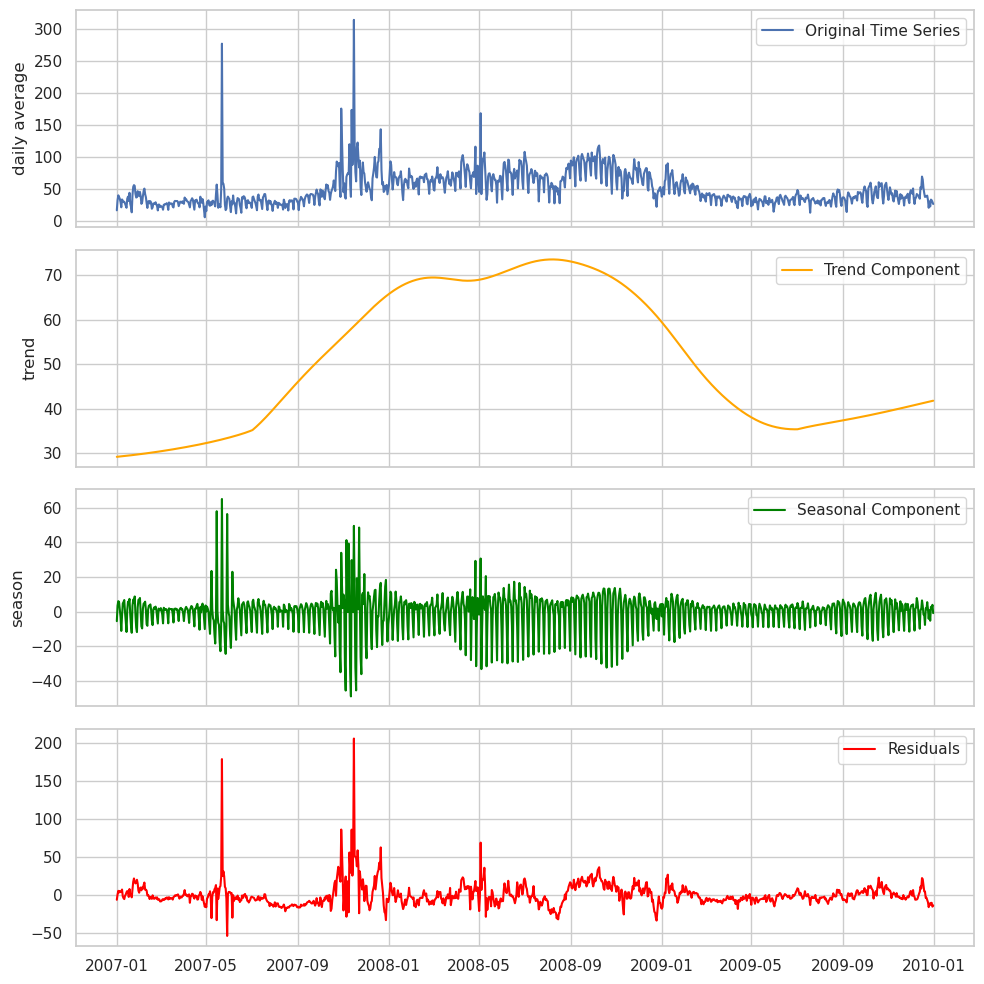

In [49]:
# Set Seaborn style
sns.set(style="whitegrid")

#Plot the decompositions with smaller points for residuals and grids using Seaborn
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot original time series
sns.lineplot(data=ts, ax=axes[0], label='Original Time Series')
axes[0].legend()
axes[0].grid(True)

# Plot trend component
sns.lineplot(data=res.trend, ax=axes[1], label='Trend Component', color='orange')
axes[1].legend()
axes[1].grid(True)

# Plot seasonal component
sns.lineplot(data=res.seasonal, ax=axes[2], label='Seasonal Component', color='green')
axes[2].legend()
axes[2].grid(True)

# Plot the residuals in a more detailed way
axes[3].plot(res.resid, label='Residuals', color='red')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

### MSTL decomposition

In [86]:
# Melt dataframe
melted_df = pd.melt(train, id_vars=['PRICES', 'month', 'day', 'year', 'day of week'],
                    var_name='Hour', value_name='Price')

# Extract Hour
melted_df['Hour'] = melted_df['Hour'].str.extract('(\d+)')

# Change to numeric
melted_df['Hour'] = pd.to_numeric(melted_df['Hour']) - 1

# Combine 'PRICES' and 'Hour'
melted_df['Date'] = pd.to_datetime(melted_df['PRICES']) + pd.to_timedelta(melted_df['Hour'], unit='h')

# Keep only the 'Date' and 'Price' columns
final_df = melted_df[['Date', 'Price']]

final_df.sort_values(by='Date', inplace=True)
final_df.set_index('Date', inplace=True)

final_df

/tmp/ipykernel_542/4162272459.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.sort_values(by='Date', inplace=True)


,Price
Date,
2007-01-01 00:00:00,24.31
2007-01-01 01:00:00,24.31
2007-01-01 02:00:00,21.71
2007-01-01 03:00:00,8.42
2007-01-01 04:00:00,0.01
...,...
2009-12-31 19:00:00,36.00
2009-12-31 20:00:00,29.00
2009-12-31 21:00:00,24.82


In [89]:
from statsmodels.tsa.seasonal import MSTL

stl_kwargs = {"seasonal_deg": 0} 
mstl = MSTL(final_df, periods=(24, 24*7), stl_kwargs=stl_kwargs)
res_mstl = mstl.fit()

/tmp/ipykernel_542/4042282510.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


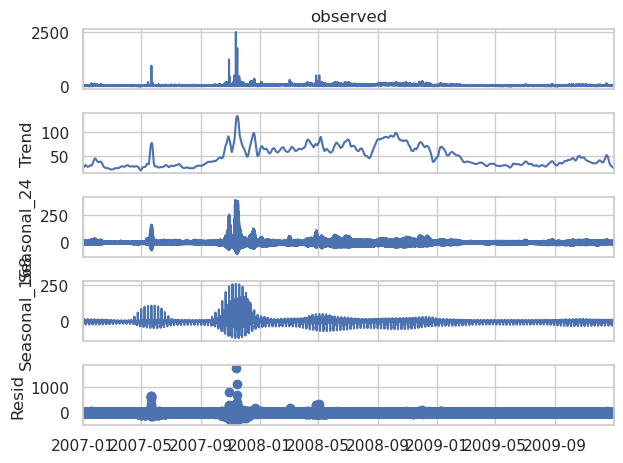

In [91]:
ax = res_mstl.plot()
plt.tight_layout()

### Average Price plots

In [ ]:
train.shape
indices = train[train['daily average']>250].index #maybe remove these
train=train.drop(indices)

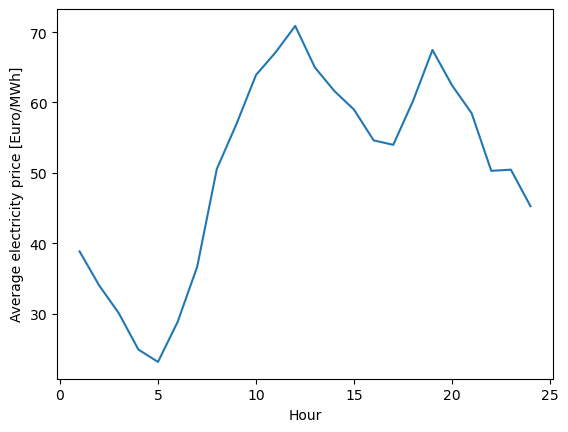

array([38.83812044, 33.99355839, 30.05389599, 24.88116788, 23.12443431,
       28.80376825, 36.65219891, 50.54479015, 56.92439781, 63.9117427 ,
       67.13242701, 70.88373175, 64.99515511, 61.6182573 , 58.98109489,
       54.61488139, 53.98165146, 60.16250912, 67.46607664, 62.43669708,
       58.46425182, 50.28571168, 50.45126825, 45.25933394])

In [34]:
hours = train.select_dtypes(include=["int64", "float64"]).columns

hour_means=np.zeros(24)
for i in range(24):
    hour_means[i]=np.mean(train[hours[i]]) 
plt.plot(np.array(range(1,25)),hour_means)
plt.xlabel('Hour')
plt.ylabel('Average electricity price [Euro/MWh]')
plt.show()

hour_means

In [22]:
months = np.array(range(12))
print(months)

abs((months - 3)// 6)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int32)

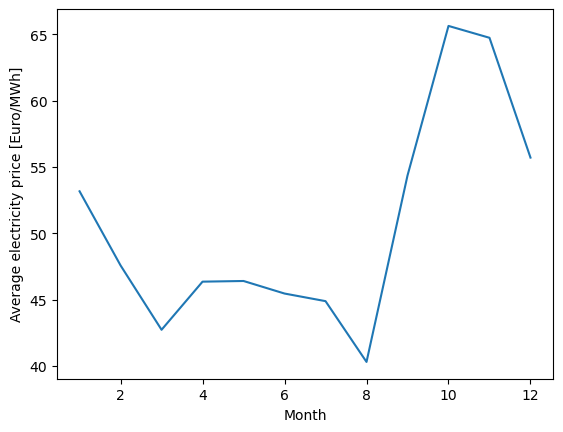

In [35]:
months=train['month'].unique()
monthly_means=np.zeros(12)
for i in range(12):
    monthly_values=train[train['month']==months[i]]['daily average']
    monthly_means[i]=np.mean(monthly_values)
plt.plot(np.array(range(1,13)), monthly_means)
plt.xlabel('Month')
plt.ylabel('Average electricity price [Euro/MWh]')
plt.show()

#correct, checked against excel

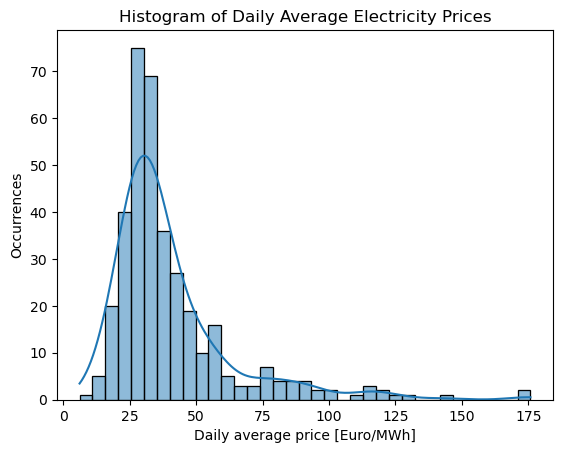

In [26]:
sb.histplot(train[train["year"]==2007]['daily average'], kde=True) 
plt.title('Histogram of Daily Average Electricity Prices')
plt.ylabel('Occurrences')
plt.xlabel('Daily average price [Euro/MWh]')
plt.show()
# do we need to go into possible distributions/time series models? 
# correlations?

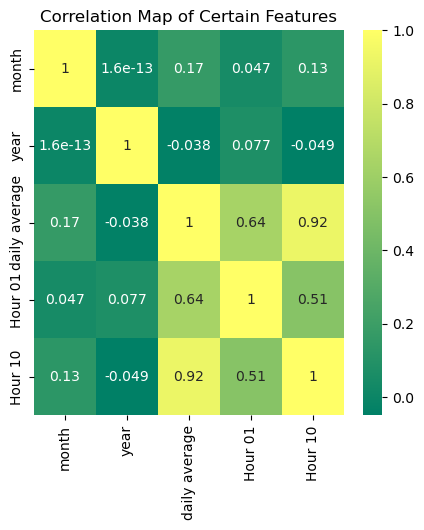

In [8]:
# a correlation heat map
corr = train[['month', 'year', 'daily average','Hour 01', 'Hour 10' ]].corr()
p=2
plt.figure(figsize=(5,5))
sb.heatmap(corr, annot=True, cmap='summer')
plt.title('Correlation Map of Certain Features')
plt.show()

In [ ]:
hour_means=np.zeros([12,24])
max_hour=np.zeros(12)
for i in range(0,12):
    mask=train['month']==i+1
    hours = train[mask].iloc[:,1:25].columns
    for j in range(0,24):    
        hour_means[i,j]=np.mean(train[hours[j]][mask]) 
    max_hour[i]=(np.squeeze(np.array(np.where(hour_means[i,:]==max(hour_means[i,:])))) )

print(max_hour)
hour_means=np.transpose(hour_means)





sb.lineplot(hour_means, palette= ['blue','blue','blue','red','red','red','red','red','red','blue','blue','blue'] )



# Example condition: columns where the mean is greater than 0.5
condition = (max_hour==11)

print(sb.color_palette("rocket"))